In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import spacy
from sentence_transformers import SentenceTransformer, util

In [2]:
df = pd.read_csv("kaffee_reviews.csv")
sentences = df.review

In [3]:
model = SentenceTransformer("distiluse-base-multilingual-cased")
nlp = spacy.load("de_core_news_sm")

In [4]:
def noun_tagger(sentence_list, nlp=None):
    nlp = nlp if nlp is not None else spacy.load("de_core_news_sm")
    noun_list = []
    for sentence in sentence_list:
        doc = nlp(sentence)
        noun_list.append([w.text for w in doc if w.tag_ == "NN" or w.tag_ == "NNP"])
    return noun_list

embeddings = model.encode(sentences, convert_to_tensor=True)
token_lists = noun_tagger(sentences, nlp)

In [5]:
cos_sim = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()
dist = torch.cdist(embeddings, embeddings, p=2, compute_mode="donot_use_mm_for_euclid_dist").cpu().numpy()

In [53]:
graph = nx.Graph()
graph.add_nodes_from([(i, {"embedding": embeddings[i], "text": sentences[i], "nouns": token_lists[i]})
                      for i in range(len(sentences))])

In [54]:
n_edges = 2
for i in range(len(sentences)):
    # cos_sim_ = np.argsort(cos_sim[i])[::-1][1:]
    dist_ = np.argsort(dist[i])[1:]
    graph.add_edges_from([(i, j, {"cos_sim": cos_sim[i][j], "dist": dist[i][j]}) for j in dist_[:n_edges]])

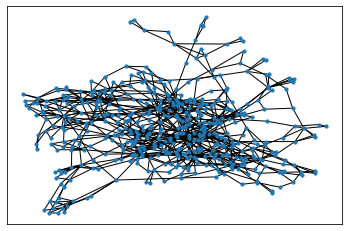

In [55]:
pos = nx.spring_layout(graph, weight="dist")
nx.draw_networkx_nodes(graph, pos, node_size=10)
nx.draw_networkx_edges(graph, pos)

In [64]:
from networkx.algorithms import community
from operator import itemgetter
import matplotlib.pyplot as plt
import itertools

In [95]:
weight = "dist"
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G, weight=weight)
    return max(centrality, key=centrality.get)

def heaviest(G):
    u, v, w = max(G.edges(data=weight), key=itemgetter(2))
    return (u, v)

comp = community.girvan_newman(graph, most_valuable_edge=most_central_edge)
comm = []

In [63]:
k = 20
limited = itertools.takewhile(lambda c: len(c) <= k, comp)

for communities in itertools.islice(comp, k):
    comm.append(communities)
    print(tuple(sorted(c) for c in communities))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 230, 231, 23

In [77]:
c = list(comm[-2])
len(c)

20

In [56]:
c = list(community.greedy_modularity_communities(graph))
len(c)

16

In [78]:
for i in c:
    print(len(i))
print(sum([len(i) for i in c]))

38
39
32
20
26
15
23
32
22
35
18
30
34
25
20
13
19
6
6
11
464


In [79]:
labels = {}
for i, commun in enumerate(c):
    for node in commun:
        labels[node] = i

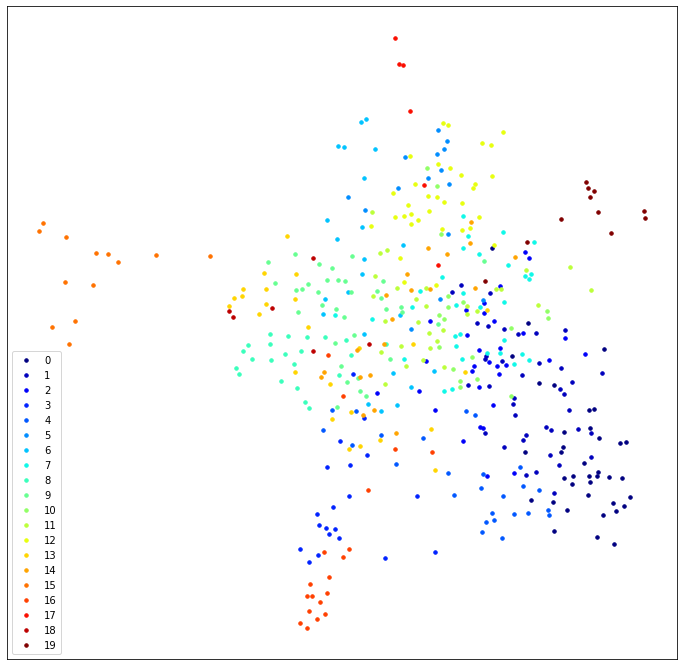

In [83]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

plt.figure(figsize=(12,12))
cmap = get_cmap(len(c), "jet")
pos = nx.spring_layout(graph, weight="dist")
# nx.draw_networkx_edges(graph, pos)
for i, commun in enumerate(c):
    nx.draw_networkx_nodes(graph, pos, node_size=12, nodelist=commun, node_color=np.atleast_2d(cmap(i)), label=i)
# nx.draw_networkx_labels(graph, pos, labels, font_size=12)

plt.legend()
plt.savefig("labels_and_colors.png") # save as png
plt.show() # d


In [81]:
commun_nouns = [np.concatenate([graph.nodes[node]["nouns"] for node in commun]) for commun in c]
unique = [np.unique(commun_nouns_, return_counts=True) for commun_nouns_ in commun_nouns]

In [82]:
#unique[0][1].argsort()[::-1]
for k in range(len(c)):
    community_ = k
    i = 5
    sorted_ = unique[community_][1].argsort()[::-1]
    print(unique[community_][0][sorted_[:i]], unique[community_][1][sorted_[:i]])

['Kaffee' 'Geschmack' 'Sorten' 'Preis' 'Geld'] [46 12  8  8  5]
['Kaffee' 'Geschmack' 'Gepa' 'Verpackung' 'Preis'] [47 13  8  7  7]
['Kaffee' 'Geschmack' 'Freunde' 'Tag' 'Konzept'] [44  6  4  4  4]
['Kaffee' 'Espresso' 'Geschmack' 'Aroma' 'Gepa'] [10 10  6  6  4]
['Espresso' 'Geschmack' 'Kaffee' 'Bohnen' 'Sterne'] [15  9  9  5  5]
['Kaffee' 'Geschmack' 'Preis' 'Versand' 'Verpackung'] [13  7  6  4  4]
['Kaffee' 'Geschmack' 'Produkt' 'Bio' 'Preis'] [10  8  5  5  3]
['Kaffee' 'Geschmack' 'Getreidekaffee' 'Alternative' 'kaffee'] [24  6  4  3  3]
['Kaffee' 'Bio' 'Fairtrade' 'REWE' 'Rewe'] [18  9  6  5  4]
['Kaffee' 'Aroma' 'Bohnen' 'Geschmack' 'Preis'] [34 16 11 10  9]
['Kaffee' 'Sterne' 'Preis' 'Lieblingskaffee' 'Geschmack'] [21 11  6  3  3]
['Kaffee' 'Preis' 'Geschmack' 'Bohnen' 'Espresso'] [37 11 10  5  5]
['Kaffee' 'Geschmack' 'Aroma' 'Gewissen' 'Hilfe'] [33 10  5  3  2]
['Geschmack' 'Aroma' 'Mischung' 'tag' 'Röstaroma'] [7 2 2 1 1]
['Kaffee' 'Espresso' 'Geschmack' 'Milch' 'Preis'] [11 

In [88]:
graph.edges((0, 72))
s_graph = nx.Graph()
s_graph.add_nodes_from([(i, {"nodes": c[i]})
                      for i in range(len(c))])

In [107]:
n_edges = 2
for i in range(len(c)):
    for j in range(len(c)):
        if i != j:
            edge_boundary = list(nx.edge_boundary(graph, c[i], c[j], data=weight))
            if edge_boundary:
                u, v, w = min(edge_boundary, key=itemgetter(2))
                s_graph.add_edge(i, j, weight=w)

--------------
420 252 0.523287
--------------
375 428 0.6280279
--------------
--------------
305 65 0.6223988
--------------
77 212 1.0090139
--------------
--------------
429 105 0.85782844
--------------
--------------
--------------
--------------
292 204 0.68889284
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
252 420 0.523287
--------------
--------------
459 428 0.60324264
--------------
--------------
8 81 0.7321231
--------------
255 192 0.6150421
--------------
382 386 1.085955
--------------
275 371 0.5379709
--------------
--------------
--------------
300 269 0.74412286
--------------
380 283 0.54843664
--------------
233 357 0.6367227
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
428 375 0.6280279
--------------
428 459 0.60324264
--------------
--------------
428 141 0.675705
--------------
4 65 0.5831539
----

In [113]:
c_ = list(community.greedy_modularity_communities(s_graph))
len(c_)
for i in c_:
    print(i)

frozenset({16, 9, 3, 15})
frozenset({0, 1, 5})
frozenset({12, 13, 6})
frozenset({10, 4, 14})
frozenset({8, 18, 11})
frozenset({17, 2})
frozenset({19, 7})


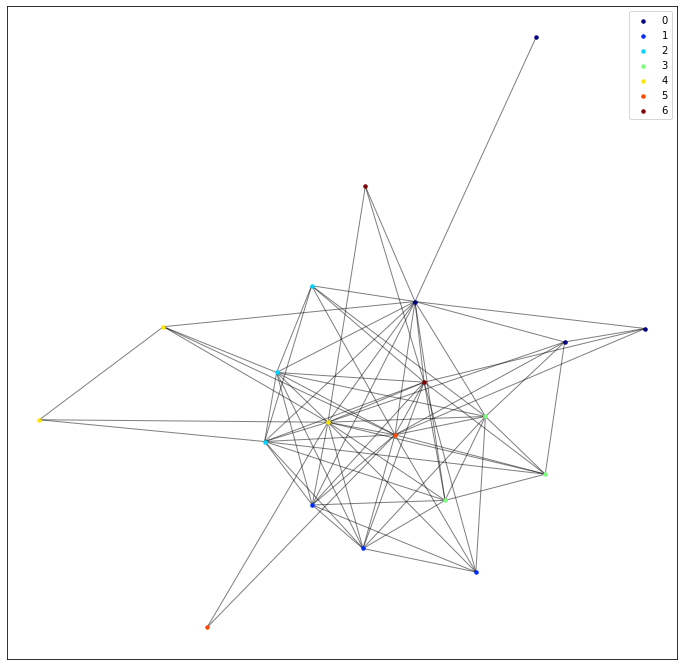

In [115]:
plt.figure(figsize=(12,12))
cmap = get_cmap(len(c_), "jet")
pos = nx.spring_layout(s_graph, weight=weight)
nx.draw_networkx_edges(s_graph, pos, alpha=0.5)
for i, commun in enumerate(c_):
    nx.draw_networkx_nodes(s_graph, pos, node_size=12, nodelist=commun, node_color=np.atleast_2d(cmap(i)), label=i)
# nx.draw_networkx_labels(graph, pos, labels, font_size=12)

plt.legend()
plt.show() # d

frozenset({16, 9, 3, 15})
frozenset({0, 1, 5})
frozenset({12, 13, 6})
frozenset({10, 4, 14})
frozenset({8, 18, 11})
frozenset({17, 2})
frozenset({19, 7})
